#### Reproduce key figures from Alarcon, et al. 2019

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pyccl as ccl

import sys
sys.path.append('../python')

import som

from astropy.table import Table, vstack
from matplotlib.colors import LogNorm

In [3]:
rng = np.random.RandomState(seed=44)

##### Read in the data

In [4]:
pz_path = '/global/cscratch1/sd/belaa/lsst/repos/pz_bayes/data/feature_likelihood/'

In [5]:
gc_table = Table.read(os.path.join(pz_path, 'dc2_image_photoz_magerr_10y_cuts.fits'), format='fits')

del_dec = (np.max(gc_table['dec_true']) - np.min(gc_table['dec_true']))
del_ra = (np.max(gc_table['ra_true']) - np.min(gc_table['ra_true']))
corr_ra = np.cos(np.mean(np.abs(gc_table['dec_true'])) * np.pi / 180)

In [6]:
print('There are {} objects in this catalog over {} sq degrees.'.format(len(gc_table), int(del_dec * del_ra * corr_ra)));

There are 47188507 objects in this catalog over 326 sq degrees.


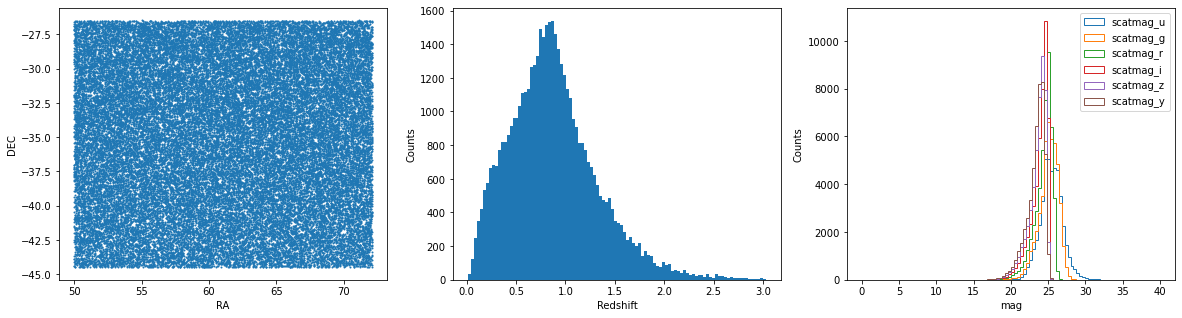

In [10]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
axs = axs.ravel()

axs[0].scatter(gc_table['ra_true'][::1000], gc_table['dec_true'][::1000], s=1)
axs[0].set_xlabel('RA')
axs[0].set_ylabel('DEC')

axs[1].hist(gc_table['redshift_true'][::1000], bins=100)
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel('Counts')

rrange = (0,40)
axs[2].hist(gc_table['scatmag_u'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_u')
axs[2].hist(gc_table['scatmag_g'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_g')
axs[2].hist(gc_table['scatmag_r'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_r')
axs[2].hist(gc_table['scatmag_i'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_i')
axs[2].hist(gc_table['scatmag_z'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_z')
axs[2].hist(gc_table['scatmag_y'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_y')
axs[2].legend(loc='best');
axs[2].set_xlabel('mag')
axs[2].set_ylabel('Counts');

#### Section 3: Simulations
##### Prepare the data

Trim sample to be between `0.2 < z < 1.2`:

In [6]:
z_beg = 0.2
z_end = 1.2

mask_z = np.logical_and(gc_table['redshift_true'] > z_beg, gc_table['redshift_true'] < z_end)
data = gc_table[mask_z]

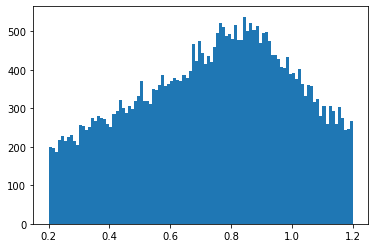

In [7]:
plt.hist(data['redshift_true'][::1000], bins=100);

Make sure we've gotten rid of outlier magnitudes (huge 10-yr depth errors get assigned mag=99):

In [7]:
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    print(np.max(data['scatmag_'+band]), np.max(data['mag_true_'+band]))

99.0 30.67118
99.0 28.193312
27.174185 26.926336
24.999998 25.275396
25.914871 25.789764
26.816427 25.888395


In [7]:
mask_mag = np.logical_and(data['scatmag_u'] < 99.0, data['scatmag_g'] < 99.0)
data = data[mask_mag]

In [9]:
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    print(np.max(data['scatmag_'+band]))

34.999645
34.790775
26.928549
24.999998
25.911364
26.816427


In [8]:
len(data)

32985872

Let's look at the redshift histogram once again:

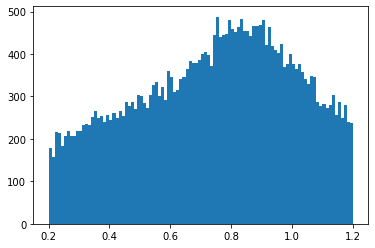

In [12]:
plt.hist(data['redshift_true'][::1000], bins=100);

Apply redshift binning consistent with 20 bins equally spaced in comoving distance:

In [21]:
from astropy.cosmology import Planck15 as LCDM

In [22]:
def get_redshift_bins(zmin=0.2, zmax=1.2, nbins=20, model=LCDM, plot=False):
    z = np.linspace(zmin, zmax, 5 * nbins + 1)
    d = model.comoving_distance(z).value
    d_grid = np.linspace(d[0], d[-1], nbins + 1)
    z_grid = np.interp(d_grid, d, z)
    if plot:
        plt.plot(z, d, '.')
        plt.plot(z_grid, d_grid, 'ro')
        for d in d_grid:
            plt.axhline(d, ls=':')
        for z in z_grid:
            plt.axvline(z, ls=':')
    zc = 0.5 * (z_grid[1:] + z_grid[:-1])
    dV = model.differential_comoving_volume(zc).value
    return z_grid, zc, dV

In [23]:
zbins, zc, dV = get_redshift_bins()

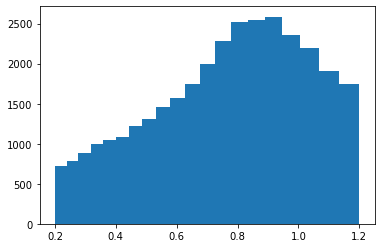

In [12]:
counts, _ , _ = plt.hist(data['redshift_true'][::1000], bins=zbins)

- Generate tracer sample by randomly sampling to maintain constant comoving density per bin. 
- Find the number of galaxies to sample per bin by calculating and then dividing by the comoving volume at the center of each bin.

In [35]:
#Is there a difference between the comoving volume at bin center and the average of the differential comoving volume integrated over the width of the bin?
V = LCDM.comoving_volume(zc).value

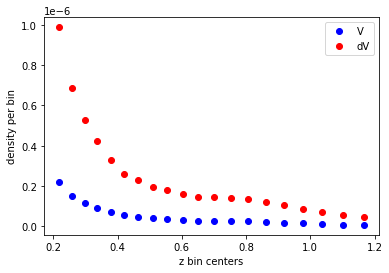

In [50]:
plt.plot(zc, counts / V, 'bo', label='V')
plt.plot(zc, counts / (dV * zc), 'ro', label='dV')
plt.xlabel('z bin centers')
plt.ylabel('density per bin')
plt.legend();

In [11]:
2e5 / (zbins[-1] - zbins[-2])

2991122.352809758

In [12]:
density = 3e-6
V = (dV * zc)

In [13]:
n_per_bin = density * V

In [14]:
n_per_bin

array([  2195.84821164,   3428.24486351,   5035.33798966,   7057.13173229,
         9529.84085213,  12486.30273438,  15955.15132791,  19960.57491702,
        24523.51059888,  29661.13548902,  35386.24849192,  41707.676316  ,
        48630.74229275,  56157.74264735,  64286.77257784,  73012.72875336,
        82327.50561706,  92218.90119599, 102673.37435496, 113673.38533616])

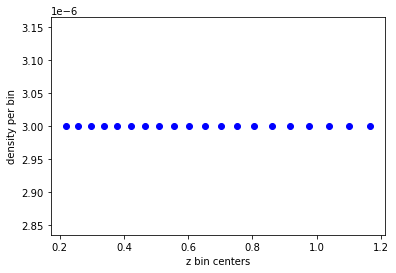

In [15]:
plt.plot(zc, n_per_bin / V, 'bo')
plt.xlabel('z bin centers')
plt.ylabel('density per bin');

In [15]:
tracers = Table(names=data.colnames)

In [16]:
n_per_bin = n_per_bin.astype(int)

In [17]:
len(data)

32985872

In [18]:
for i in range(len(zc)):
    in_bin = np.logical_and(data['redshift_true'] > zbins[i], data['redshift_true'] <= zbins[i+1])
    in_bin_idx = np.argwhere(in_bin == True)[:,0]
    # randomly select tracer galaxies in each bin
    rndm = rng.choice(in_bin_idx, size=n_per_bin[i], replace=False)
    tracers = vstack([tracers, data[rndm]])
    data.remove_rows(rndm)

In [21]:
#data.write('../data/feature_likelihood/targets.fits', format='fits')
#tracers.write('../data/feature_likelihood/tracers.fits', format='fits')

In [19]:
len(data), len(tracers)

(32145974, 839898)

In [20]:
assert len(data) == 32985872 - len(tracers)

In [23]:
targets = data

In [24]:
len(tracers) / len(targets)

0.026127626433095477

In [5]:
targets = Table.read('../data/feature_likelihood/targets.fits', format='fits')
tracers = Table.read('../data/feature_likelihood/tracers.fits', format='fits')

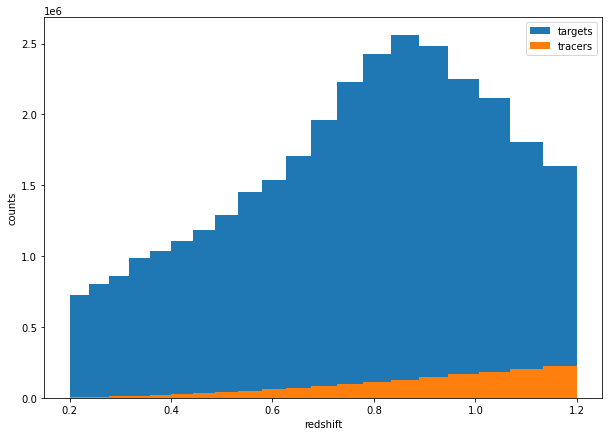

In [24]:
plt.figure(figsize=(10,7))
plt.hist(targets['redshift_true'], bins=zbins, label='targets')
plt.hist(tracers['redshift_true'], bins=zbins, weights=np.full(len(tracers), 2), label='tracers')
plt.xlabel('redshift')
plt.ylabel('counts')
plt.legend();

In [6]:
# Randomly select 1M galaxies to use for training wide and deep SOM
rand = rng.choice(len(targets), size=int(1e6), replace=False)

In [7]:
train = targets[rand]

In [8]:
ui_deep = train['mag_true_u'] - train['mag_true_i']
gi_deep = train['mag_true_g'] - train['mag_true_i']
ri_deep = train['mag_true_r'] - train['mag_true_i']
zi_deep = train['mag_true_z'] - train['mag_true_i']
yi_deep = train['mag_true_y'] - train['mag_true_i']

imag = train['scatmag_i']

gi_wide = train['scatmag_g'] - train['scatmag_i']
ri_wide = train['scatmag_r'] - train['scatmag_i']
zi_wide = train['scatmag_z'] - train['scatmag_i']

In [9]:
def normalize_features(data, colors=True):
    
    norm = (data - np.min(data)) / (np.max(data) - np.min(data))
    
    # Normalize colors between [0,1]  
    if colors:
        return(norm)
    
    # Normalize magnitudes between [0,0.1]
    else:
        return(norm / 10)
    
ui_deep = normalize_features(ui_deep)
gi_deep = normalize_features(gi_deep)
ri_deep = normalize_features(ri_deep)
zi_deep = normalize_features(zi_deep)
yi_deep = normalize_features(yi_deep)

imag = normalize_features(imag, colors=False)

gi_wide = normalize_features(gi_wide)
ri_wide = normalize_features(ri_wide)
zi_wide = normalize_features(zi_wide)

In [10]:
X_deep = np.array([ui_deep, gi_deep, ri_deep, zi_deep, yi_deep]).T
Y_deep = np.asarray(train['redshift_true'])

X_wide = np.array([imag, gi_wide, ri_wide, zi_wide]).T
Y_wide = np.asarray(train['redshift_true'])

In [11]:
# Deep SOM arguments
nside_deep = -32
niter_deep = 10

# Wide SOM arguments
nside_wide = -26
niter_wide = 10

In [ ]:
start = time.time()
som_deep = som.SelfOrganizingMap(som.Grid(nside_deep, nside_deep))
som_deep.fit(X_deep, Y_deep, maxiter=niter_deep)
print(time.time() - start)

In [ ]:
start = time.time()
som_wide = som.SelfOrganizingMap(som.Grid(nside_wide, nside_wide))
som_wide.fit(X_wide, Y_wide, maxiter=niter_wide)
print(time.time() - start)

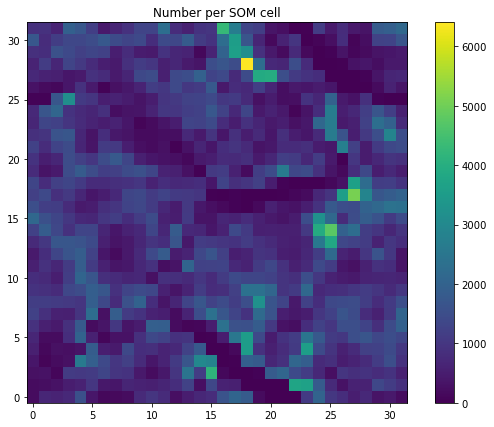

In [19]:
som_deep.plot_counts_per_cell()

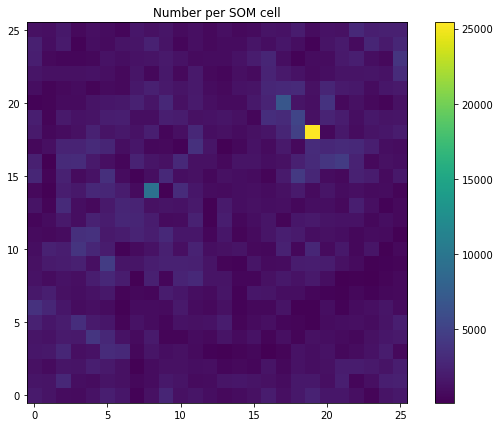

In [20]:
som_wide.plot_counts_per_cell()

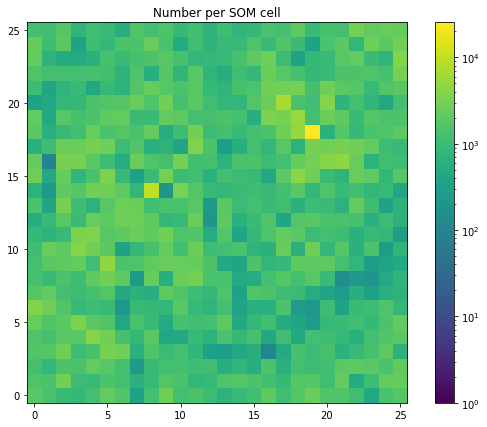

In [16]:
som_wide.plot_counts_per_cell(norm=LogNorm(vmin=1, vmax=25500))

../python/som.py:347: RuntimeWarning: Mean of empty slice
  stat = np.asarray([statistic(self._target_dist[i]) for i in range(self._mapgeom.size)])


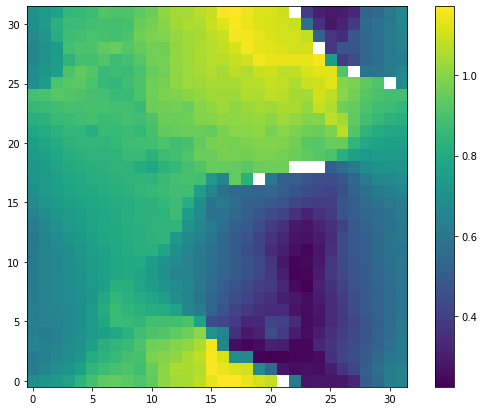

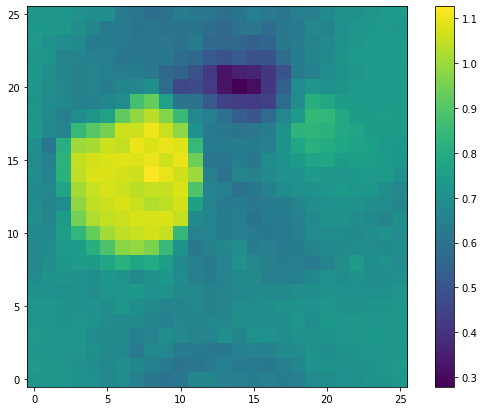

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


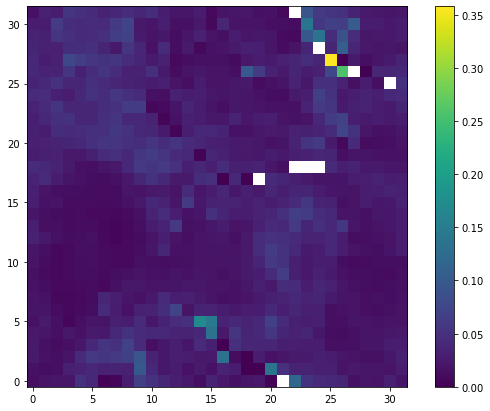

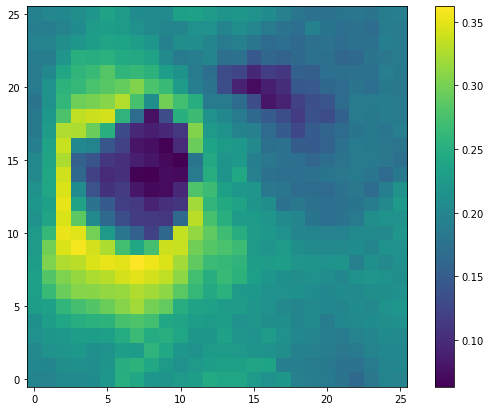

In [17]:
zmean_deep = som_deep.plot_statistic(statistic=np.nanmean, return_stat=True)
zmean_wide = som_wide.plot_statistic(statistic=np.nanmean, return_stat=True)
zstd_deep = som_deep.plot_statistic(statistic=np.nanstd, return_stat=True)
zstd_wide = som_wide.plot_statistic(statistic=np.nanstd, return_stat=True)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


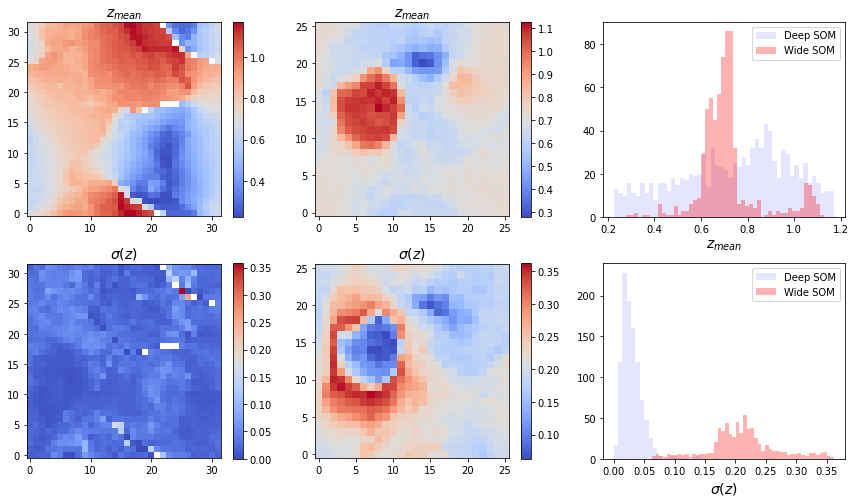

In [18]:
fig, axs = plt.subplots(2,3, figsize=(12,7))
axs = axs.ravel()

im0 = axs[0].imshow(zmean_deep.reshape(som_deep._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[0].set_title(r'$z_{mean}$', fontsize=14)
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(zmean_wide.reshape(som_wide._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[1].set_title(r'$z_{mean}$', fontsize=14)
fig.colorbar(im1, ax=axs[1])
axs[2].hist(zmean_deep, bins=50, alpha=0.1, color='b', label='Deep SOM')
axs[2].hist(zmean_wide, bins=50, alpha=0.3, color='r', label='Wide SOM')
axs[2].set_xlabel(r'$z_{mean}$', fontsize=14)
axs[2].legend()
im3 = axs[3].imshow(zstd_deep.reshape(som_deep._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[3].set_title(r'$\sigma(z)$', fontsize=14)
fig.colorbar(im3, ax=axs[3])
im4 = axs[4].imshow(zstd_wide.reshape(som_wide._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[4].set_title(r'$\sigma(z)$', fontsize=14)
fig.colorbar(im4, ax=axs[4])
axs[5].hist(zstd_deep, bins=50, alpha=0.1, color='b', label='Deep SOM')
axs[5].hist(zstd_wide, bins=50, alpha=0.3, color='r', label='Wide SOM')
axs[5].set_xlabel(r'$\sigma(z)$', fontsize=14)
axs[5].legend()
plt.tight_layout()
plt.show()

Find wide / deep cell each galaxy in training sample belongs to to $p(z|c)$ and $p(c|\hat(c))$:

In [24]:
bmu_deep = som_deep.find_bmu(X_deep)
bmu_wide = som_wide.find_bmu(X_wide)

In [48]:
np.bincount(bmu_deep) / len(bmu_deep)

array([0.000208, 0.000687, 0.000648, ..., 0.001842, 0.00194 , 0.002156])

In [92]:
len(np.bincount(bmu_wide, minlength=676))

676

In [95]:
np.bincount(bmu_wide)[0]

1939

In [96]:
np.count_nonzero(bmu_wide == 0)

1939

In [115]:
np.count_nonzero(np.bincount(bmu_wide, minlength=676))

676

Test: find distribution of deep color cells in wide SOM cell 14:

In [73]:
np.max(bmu_wide)

675

In [108]:
transfer_fn = np.empty((som_wide._mapgeom.size, som_deep._mapgeom.size))

In [109]:
transfer_fn.shape

(676, 1024)

In [98]:
train['wide_cell'] = bmu_wide
train['deep_cell'] = bmu_deep

In [118]:
counts_wide = np.bincount(bmu_wide, minlength=som_wide._mapgeom.size)
for i in range(som_wide._mapgeom.size):
    frac_wide = counts_wide[i]
    for j in range(som_deep._mapgeom.size):
        transfer_fn[i,j] = len(train[np.logical_and(train['wide_cell'] == i, train['deep_cell'] == j)]) / frac_wide

In [120]:
#np.save('transfer_fn', transfer_fn)

$p(c|\hat{c})$

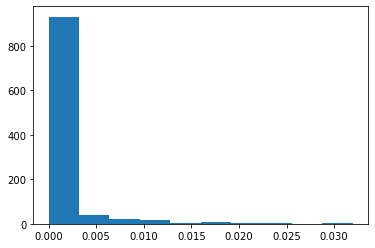

In [136]:
# probability of galaxy being in deep cell c given wide cell c_hat = 86
plt.hist(transfer_fn[86]);

In [137]:
np.sum(transfer_fn[86])

1.0

In [177]:
z_deep = som_deep._target_dist

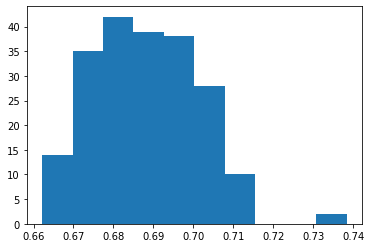

In [178]:
plt.hist(z_deep[0]);

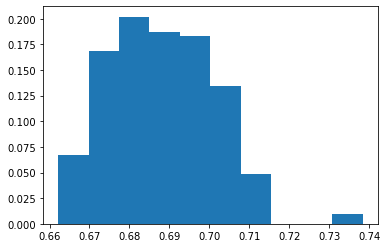

In [179]:
cc, _, _ = plt.hist(z_deep[0], weights=np.full(len(z_deep[0]), 1 / len(z_deep[0])))

In [161]:
np.sum(cc)

1.0000000000000002

In [180]:
len(z_deep[400]) / 50

24.1

In [185]:
p_zc = []
for k in range(som_deep._mapgeom.size):
    p_zc.append(np.histogram(z_deep[k], bins=50)[0] / len(z_deep[k]))

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [189]:
transfer_fn[40]

array([0., 0., 0., ..., 0., 0., 0.])

In [197]:
transfer_fn.shape

(676, 1024)

Find $z_{mean}$ for wide cell = 10:

In [224]:
sum_deep_cells = np.zeros((50, som_deep._mapgeom.size))
for i in range(som_deep._mapgeom.size):
    sum_deep_cells += p_zc[i].reshape(-1,1) * transfer_fn[69]

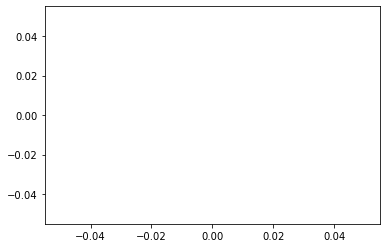

In [225]:
plt.plot(np.sum(sum_deep_cells, axis=0));

In [221]:
np.any(np.sum(sum_deep_cells, axis=0))

True

In [228]:
np.argwhere(~np.isnan(np.sum(sum_deep_cells, axis=0)))

array([], shape=(0, 1), dtype=int64)

#### Use 1 SOM and Gaussian 'cloud' of points

In [66]:
idx = 0
random_gal = rng.multivariate_normal([train['scatmag_g'][idx], train['scatmag_r'][idx], train['scatmag_i'][idx], train['scatmag_z'][idx]], 
                        np.diag([train['scaterr_g'][idx], train['scaterr_r'][idx], train['scaterr_i'][idx], train['scaterr_i'][idx]]))

In [67]:
imag = random_gal[2]

gi_wide = random_gal[0] - random_gal[2]
ri_wide = random_gal[1] - random_gal[2]
zi_wide = random_gal[3] - random_gal[2]

In [64]:
imag = normalize_features(imag, colors=False)

gi_wide = normalize_features(gi_wide)
ri_wide = normalize_features(ri_wide)
zi_wide = normalize_features(zi_wide)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [68]:
imag

21.424199993632

In [45]:
wide_idx = som_wide.find_bmu()

(23.51114, 22.137506, 21.511206)